# Stimuli Generator

In [1]:
%matplotlib inline

import os
from pathlib import Path

import numpy as np
import scipy

import sklearn

import torch
from torch import nn, optim, utils, Tensor

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import gestalt as gs
from gestalt import sampler

/Users/han/.pyenv/versions/3.10.8/envs/dev310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

## Comparison of sampling methods

### Method 1: iid uniform sampling

Drawback: formation of clusters

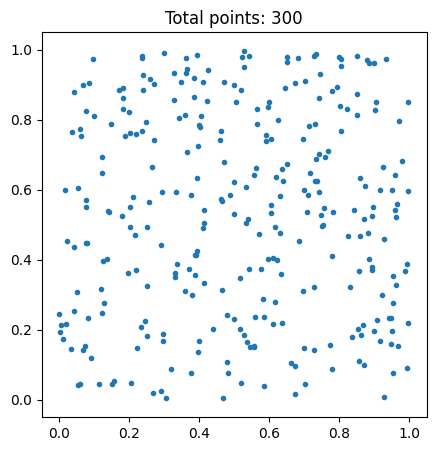

In [3]:
D = np.random.rand(300,2)
fig, ax = gs.utils.ball_plot(D)

### Method 2: random perturbation of hexagonal grid

Depending on the amount of perturbation:
- Insuffificent: still look like a hex grid
- Too much: formation of clusters

In [4]:
ρ = 0.03
# print(f'Radius={ρ}, Maximum number of balls={int(1/(np.pi*ρ**2))}')

N = int(1/ρ)
X, Y = np.meshgrid(np.arange(0,2*N), np.arange(-2*N,2*N))

# Hexagonal coordinates
B = np.asarray([[1,0], [0.5, np.sqrt(3)/2]]).T

H0 = np.asarray((X,Y)).reshape((2,-1)).T @ B * (2*ρ)
Hg = np.asarray([d for d in H0 if 0<=d[0]<=1 and 0<=d[1]<=1]) 

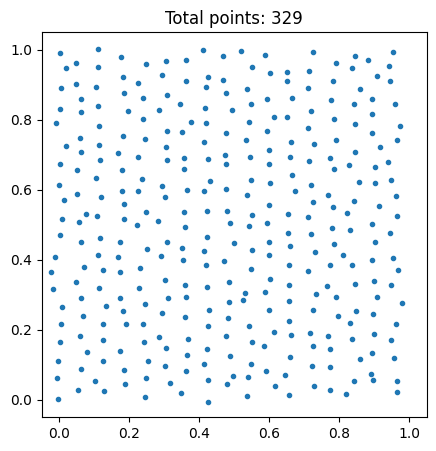

In [9]:
D = Hg + np.random.randn(len(Hg),2)*ρ*0.25

_ = gs.utils.ball_plot(D)

### Method 3: incremental sampling

Try to pack randomly as many balls as possible inside a restricted area. 

In [12]:
sfunc = gs.sampler.box()
radius = 0.025
thresh = 1e-1

%time D = gs.sampler.draw_positions(radius, sfunc, thresh=thresh)

CPU times: user 94.6 ms, sys: 3.37 ms, total: 98 ms
Wall time: 96.8 ms


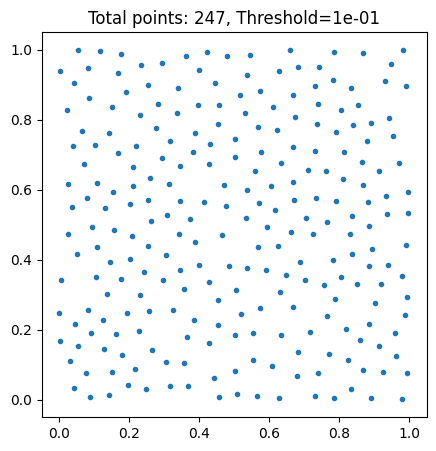

In [13]:
_ = gs.utils.ball_plot(D, thresh=thresh)

## Incremental sampling

### Effect of the threshold

Sampling becomes harder with a small threshold.

In [14]:
sfunc = gs.sampler.box()
radius = 0.1
thresh = 1e-3

%time D = gs.sampler.draw_positions(radius, sfunc, thresh=thresh)

len(D)

CPU times: user 713 ms, sys: 10.6 ms, total: 724 ms
Wall time: 724 ms


27

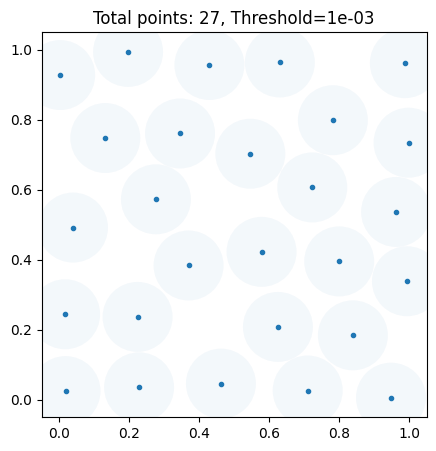

In [15]:
fig, ax = gs.utils.ball_plot(D, radius=radius, thresh=thresh)

# plt.savefig(outdir/f'thresh[{thresh:.0e}].png')

### Sampling from a contour

In [21]:
radius = 0.025
thresh = 1e-2

# %time C = sampling(radius, point_set(Xs), thresh=thresh)
%time C = sampler.draw_positions(radius, sampler.circle(inside=False), thresh=thresh)
%time D = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 80 ms, sys: 5.42 ms, total: 85.4 ms
Wall time: 81.8 ms
CPU times: user 1.28 s, sys: 8.32 ms, total: 1.29 s
Wall time: 1.29 s


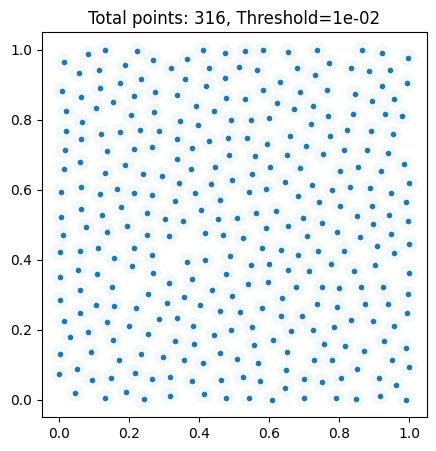

In [22]:
fig, ax = gs.utils.ball_plot(np.vstack([D, C]), radius=radius, thresh=thresh)

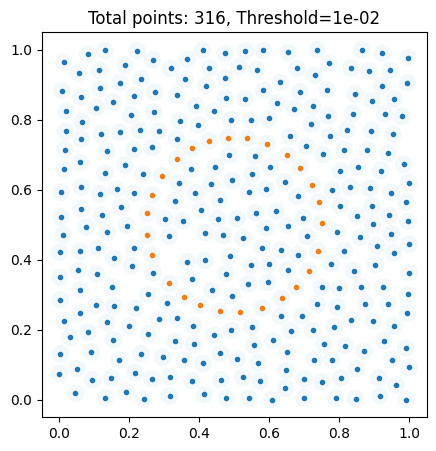

In [23]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

In [23]:
P = np.asarray ([(0.25,0.25), (0.75,0.25), (0.5,0.683), (0.25,0.25)])

radius = 0.025
thresh = 1e-3

# %time C = sampling(radius, point_set(Xs), thresh=thresh)
%time C = sampler.draw_positions(radius, sampler.segments(P), thresh=thresh)
%time D = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 751 ms, sys: 24.5 ms, total: 776 ms
Wall time: 765 ms
CPU times: user 15.1 s, sys: 115 ms, total: 15.2 s
Wall time: 15.4 s


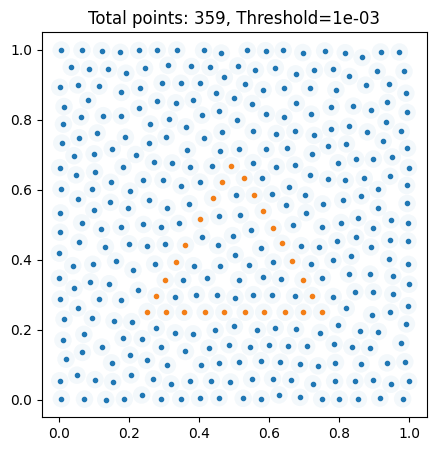

In [24]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

### Sampling from a contour of image

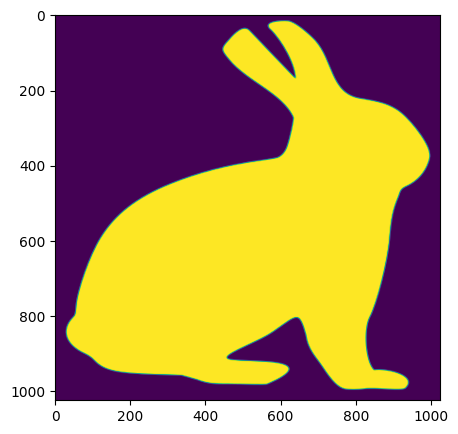

In [24]:
fname = Path('/Users/han/Dropbox/Projects/DeepBrain/Datasets/hare_1024.png')
image = plt.imread(fname)

X0 = np.mean(image, axis=-1)
plt.imshow(X0, aspect='equal')

In [25]:
X1, Xs, Gs = gs.utils.contour_from_cartoon(X0)

Xs = Xs/X1.shape  # convert to the coordinate in the box [0,1]x[0,1]

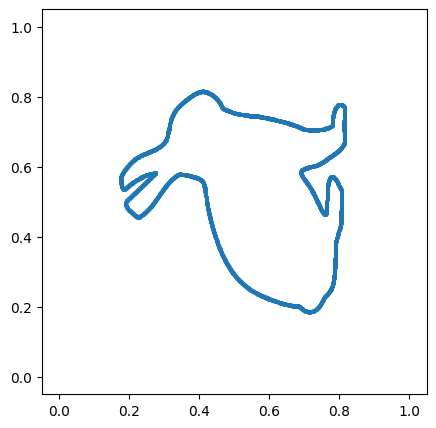

In [26]:
plt.scatter(Xs[:,0], Xs[:,1], marker='.', s=1)
ax = plt.gca()
ax.set_xlim((-0.05,1.05))
ax.set_ylim((-0.05,1.05))
ax.set_aspect('equal')   

In [29]:
radius = 0.03
thresh = 1e-2

%time C = sampler.draw_positions(radius, sampler.point_set(Xs), thresh=thresh)
%time D = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 89.6 ms, sys: 8.87 ms, total: 98.5 ms
Wall time: 91 ms
CPU times: user 903 ms, sys: 8.88 ms, total: 912 ms
Wall time: 917 ms


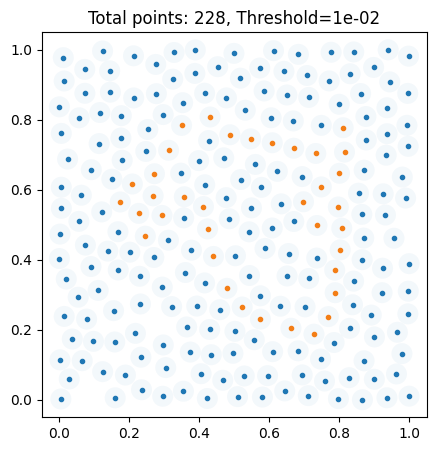

In [30]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

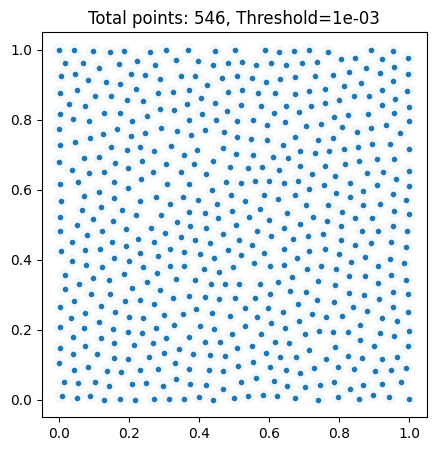

In [34]:
fig, ax = gs.utils.ball_plot(np.vstack([D,C]), radius=radius, thresh=thresh)

### Placement of patches

In [36]:
N = 512
xs, ys = np.meshgrid(range(N), range(N))
xys = np.stack([xs,ys]).reshape((2,-1)).T/N

In [37]:
xys.shape

(262144, 2)

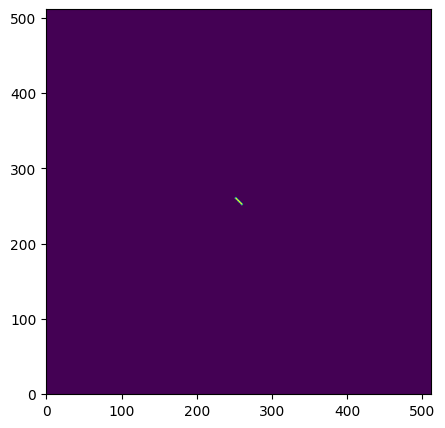

In [44]:
I = gs.patch.segment(xys-[0.5,0.5], g=[1,1], l=0.025, w=0.005, ).reshape(N,N)
# I = gs.patch.gabor(xys-[0.5,0.5], f=100, σ2=0.002, g=[1,1]).reshape(N,N)

plt.imshow(I, origin='lower')

In [126]:
f = 100
σ2 = 0.002

l=0.025
w=0.005

# pfunc = lambda z,g: gs.patch.gabor(z, g, f, σ2)
pfunc = lambda z,g: gs.patch.segment(z, g, l, w)

In [127]:
N = 512
If = gs.patch.generate_image(C, Xs, Gs, N=N, pfunc=pfunc)
Ig = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

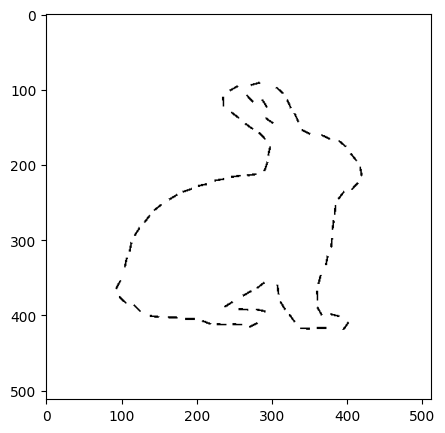

In [128]:
Im = If.copy()

Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal')
plt.set_cmap('binary')
plt.imsave(outdir/f'bunny{N}_fg.png', Im)

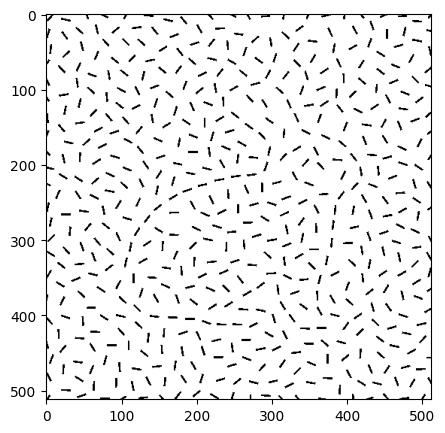

In [129]:
Im = I.copy()

Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal')
plt.set_cmap('binary')
plt.imsave(outdir/f'bunny{N}.png', Im)

# EOF